In [8]:
from model_class.colorizer import build_colorizer
from callbacks.callbacks import *

In [9]:
WEIGHTS_PATH = '5_128_2048_checkpoint.weights.h5'

In [10]:
model = build_colorizer()
model.load_weights(WEIGHTS_PATH)

### Раскрашивание изображения

Предварительно нужно преобразовать изображение в Lab формат,
<br>взять только канал l, уменьшить размер до 128*128 пикселей.
<br>Затем нормализовать l канал до [0, 1]
<br>Предсказанные цвета нужно денормализовать, совместить с l каналом
<br>и перевести в необходимую цветовую палитру из Lab 

In [11]:
import cv2

IMAGE_PATH = 'exp.jpg'

image = cv2.imread(IMAGE_PATH)

image = cv2.resize(image, (128, 128))
image_real = image

image = cv2.cvtColor(image, cv2.COLOR_BGR2LAB).astype(np.float32)
image_l = image[:, :, 0]

l_norm = image_l / 255.0  # нормализация
l_norm = l_norm[None, ..., None]
image_ab_pred = model.predict(l_norm)[0] 

image_pred = image_ab_pred * 128.0 + 128.0  # денормализация

pred_lab = np.concatenate(
    [image_l[..., None], image_pred], axis=-1).astype(np.uint8)

pred_rgb = cv2.cvtColor(pred_lab, cv2.COLOR_LAB2RGB)  # готовое изображение

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


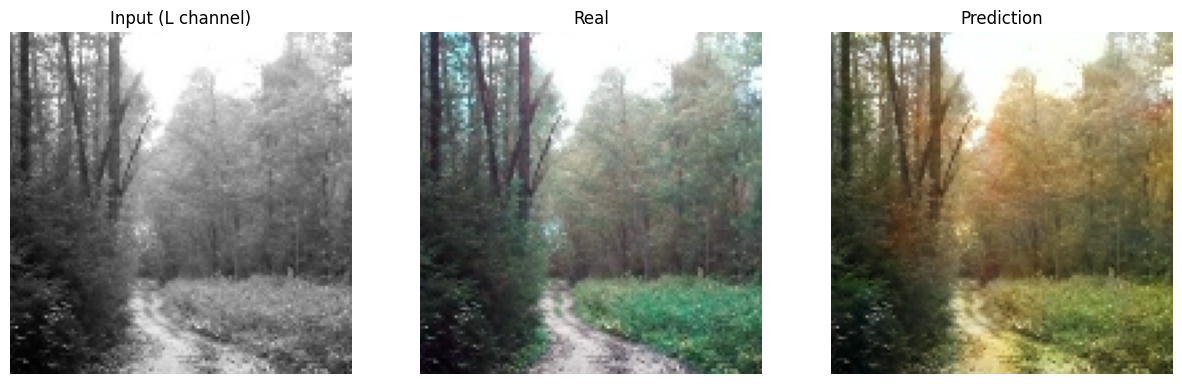

In [12]:
import matplotlib.pyplot as plt

image = cv2.cvtColor(image.astype(np.uint8), cv2.COLOR_LAB2RGB)

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(image_l, cmap='gray')
plt.title('Input (L channel)')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(image_real)
plt.title('Real')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(pred_rgb)
plt.title('Prediction')
plt.axis('off')

plt.show()

### Код для обучения с callbacks

In [ ]:
from keras.api.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras.api.callbacks import EarlyStopping

log_dir = ''
log_dir_local = ''
train_ds = []
val_ds = []

tensorboard_cb2 = GradientLoggingTensorBoard(
    log_dir=log_dir_local,
    histogram_freq=1,
    write_graph=True
)

image_logger = ImageLogger(log_dir_local, val_data=val_ds, max_images=4)

layer_hist_cb = LayerHistograms(log_dir_local)

cpy = Cpy(log_dir, log_dir_local)

model.compile(optimizer=keras.optimizers.Adam(
    clipnorm=5.0, weight_decay=1e-4*8, learning_rate=0.001), loss='mse')

model.fit(train_ds, validation_data=val_ds, epochs=50, callbacks=[
    layer_hist_cb, tensorboard_cb2, image_logger, cpy,
    ModelCheckpoint(
        'path',
        mode='min', monitor='val_loss', save_best_only=True,
        save_weights_only=True),
    ReduceLROnPlateau(factor=0.5, cooldown=0, patience=7, verbose=1, min_lr=0.5e-6),
    EarlyStopping(monitor='val_loss', patience=15, min_delta= 0.01, mode='min')
])

Model: "functional_16"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 64, 64,    │      1,280 │ input_layer_2[0]… │
│ (Sequential)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_1        │ (None, 32, 32,    │    147,584 │ sequential[0][0]  │
│ (Sequential)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_2        │ (None, 16, 16,    │    296,192 │ sequential_1[0][… │
│ (Sequential)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_3        │ (None, 8, 8, 512) │  1,182,208 │ sequential_2[0][… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_4        │ (None, 4, 4,      │  4,723,712 │ sequential_3[0][… │
│ (Sequential)        │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_5        │ (None, 2, 2,      │ 18,884,608 │ sequential_4[0][… │
│ (Sequential)        │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_6        │ (None, 1, 1,      │ 37,758,976 │ sequential_5[0][… │
│ (Sequential)        │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_7        │ (None, 2, 2,      │ 37,750,784 │ sequential_6[0][… │
│ (Sequential)        │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_6       │ (None, 2, 2,      │          0 │ sequential_7[0][… │
│ (Concatenate)       │ 4096)             │            │ sequential_5[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_8        │ (None, 4, 4,      │ 37,749,760 │ concatenate_6[0]… │
│ (Sequential)        │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_7       │ (None, 4, 4,      │          0 │ sequential_8[0][… │
│ (Concatenate)       │ 2048)             │            │ sequential_4[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_9        │ (None, 8, 8, 512) │  9,437,696 │ concatenate_7[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_8       │ (None, 8, 8,      │          0 │ sequential_9[0][… │
│ (Concatenate)       │ 1024)             │            │ sequential_3[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_10       │ (None, 16, 16,    │  2,359,552 │ concatenate_8[0]… │
│ (Sequential)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_9       │ (None, 16, 16,    │          0 │ sequential_10[0]… │
│ (Concatenate)       │ 512)              │            │ sequential_2[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_11       │ (None, 32, 32,    │    589,952 │ concatenate_9[0]

 Total params: 151,182,010 (576.71 MB)

 Trainable params: 151,170,234 (576.67 MB)

 Non-trainable params: 11,776 (46.00 KB)

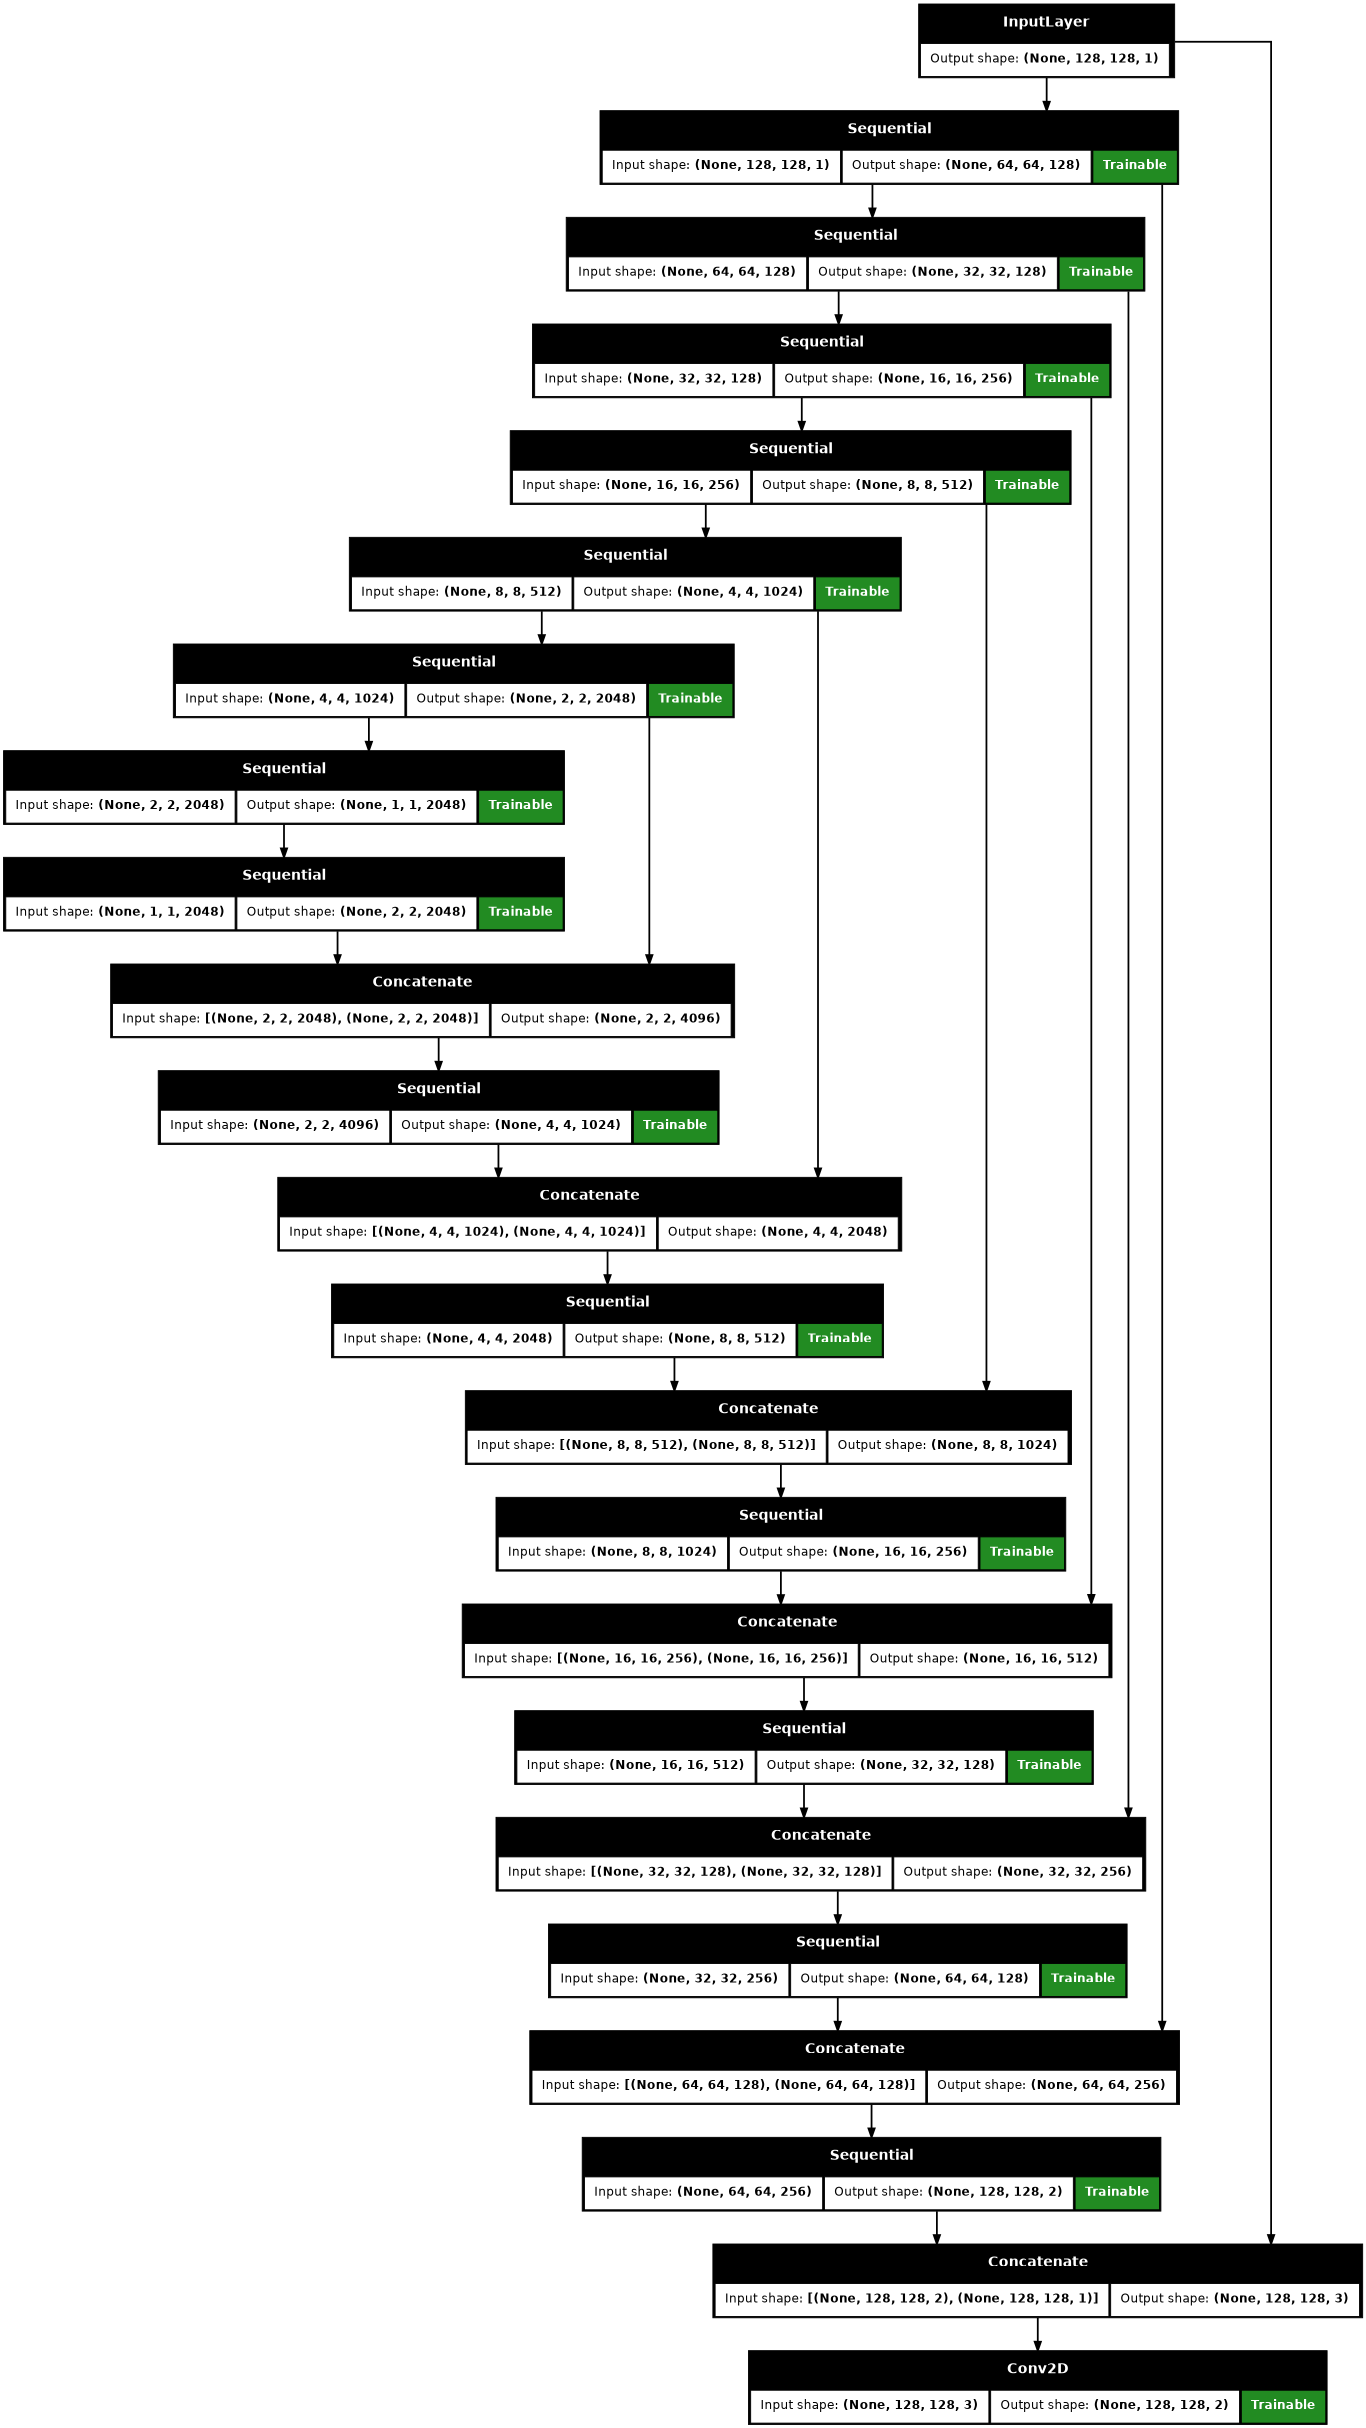

In [13]:
import keras

model.summary()
keras.utils.plot_model(model, show_shapes=True, show_trainable=True, dpi=64)